Iñigo Martin Melero

## Participante 28

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_28_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


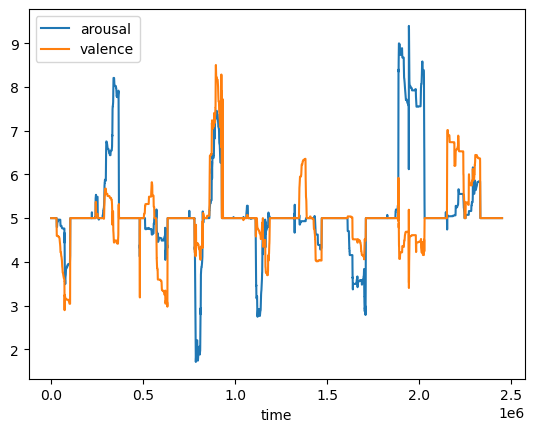

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_28_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.918  36.533  19.599  42.352  29.379     5.685     6.426   
1              1  0.915  36.737  19.607  42.390  29.379     5.808     6.467   
2              2  0.912  36.940  19.614  42.429  29.379     5.932     6.508   
3              3  0.908  37.144  19.622  42.468  29.379     6.055     6.549   
4              4  0.905  37.347  19.630  42.506  29.379     6.178     6.590   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  1.194  33.686  13.938  40.783  30.858     4.497     6.015   
2451580  2451580  1.220  33.937  13.953  40.726  30.858     4.536     6.096   
2451581  2451581  1.211  34.036  13.945  40.745  30.869     4.618     6.138   
2451582  2451582  1.207  33.461  13.933  40.726  30.851     4.456     5.976   
2451583  2451583  1.217  33.724  13.937  40.745  30.855     4.577     5.974   

         emg_trap  video  
0          11.148     10

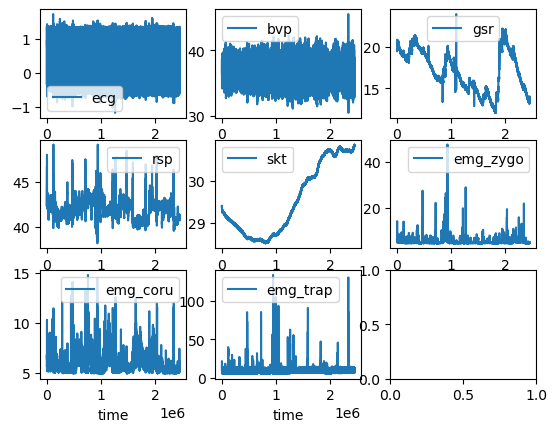

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

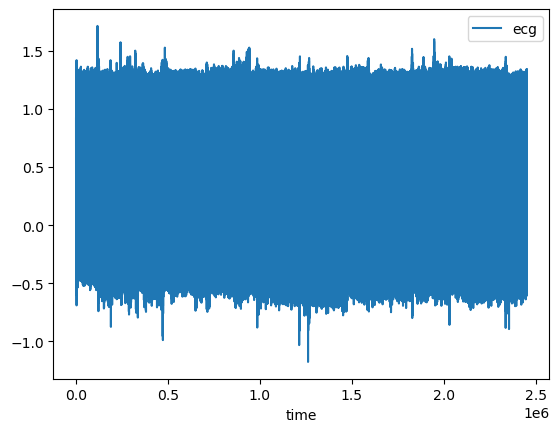

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

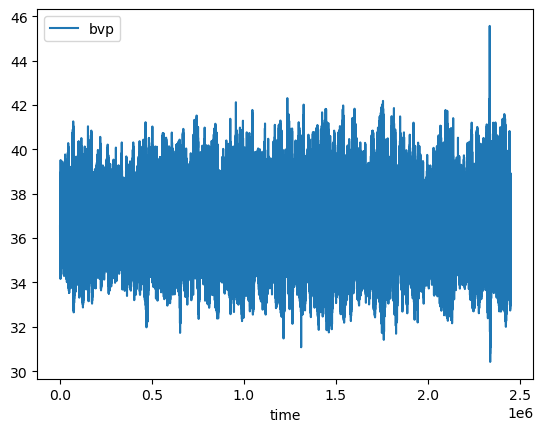

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

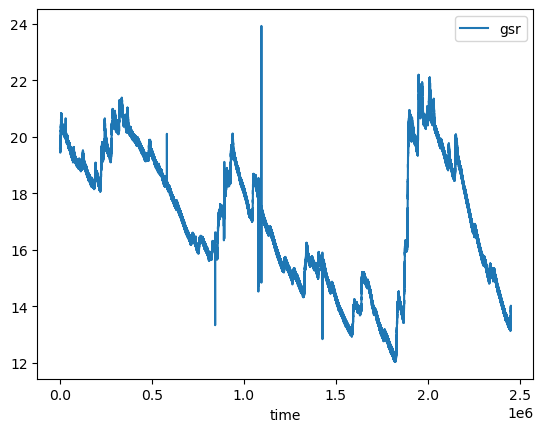

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

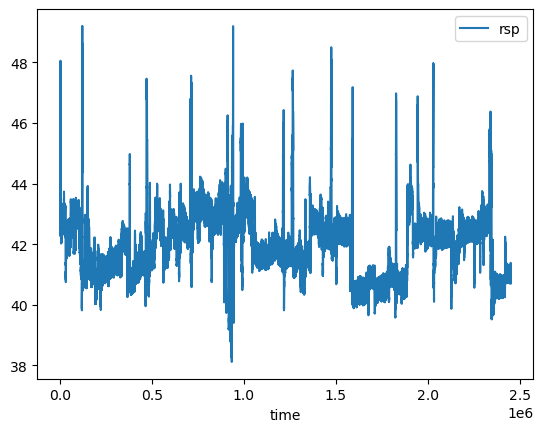

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

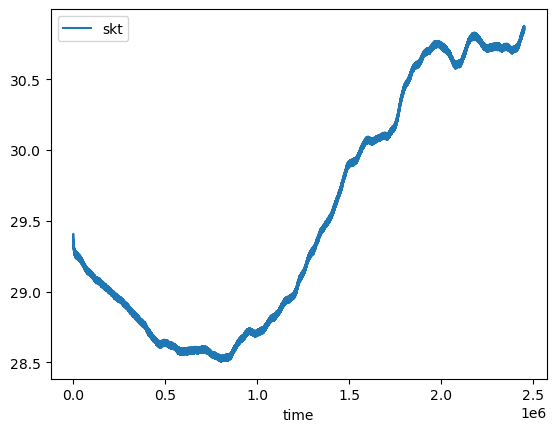

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

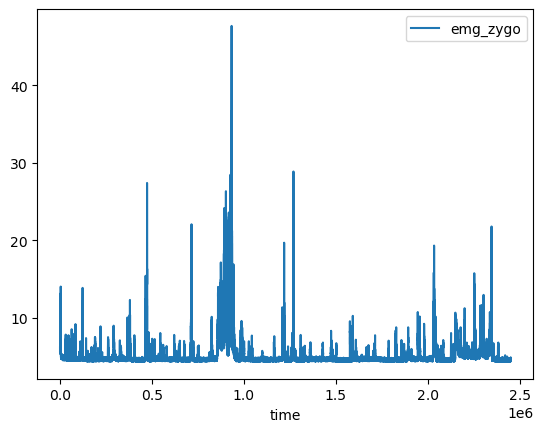

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

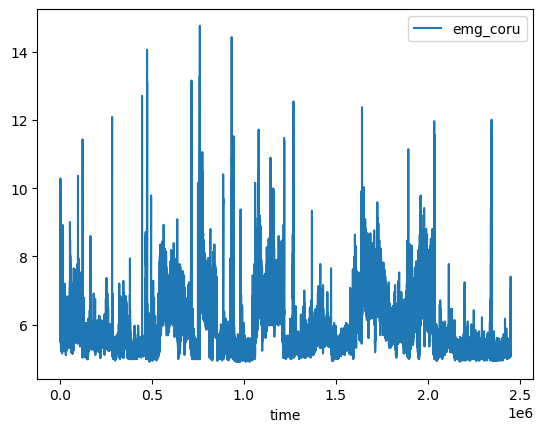

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

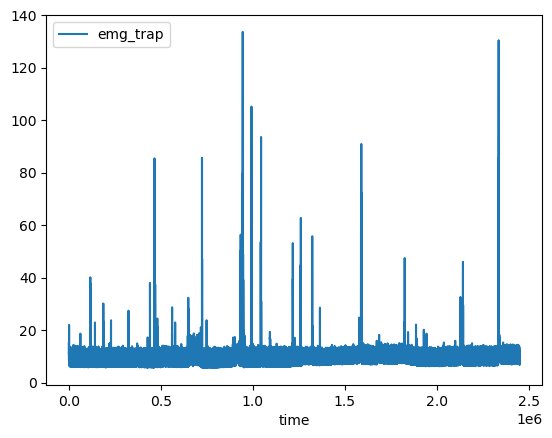

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

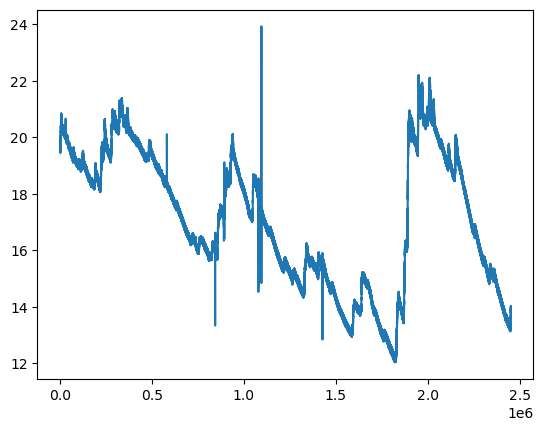

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

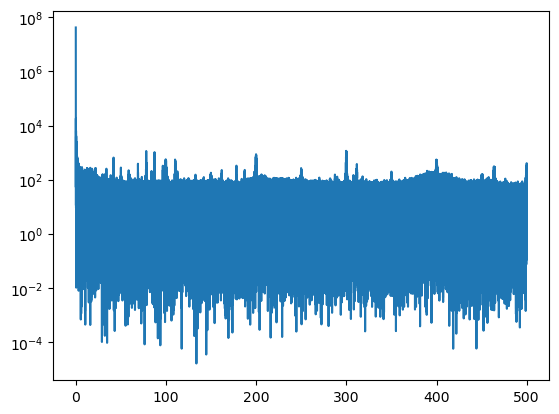

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

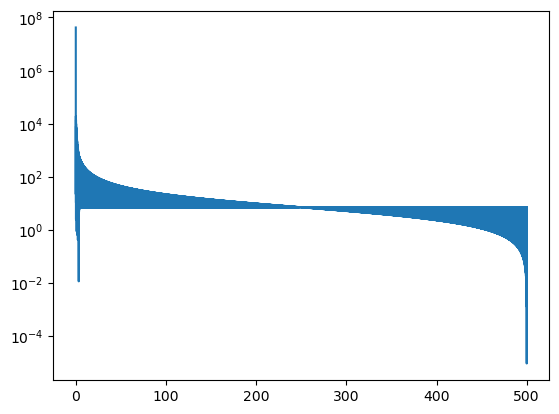

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

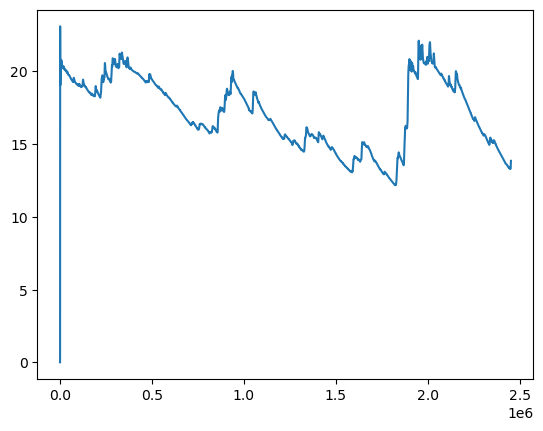

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  13.850
2451580  13.850
2451581  13.850
2451582  13.851
2451583  13.851

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

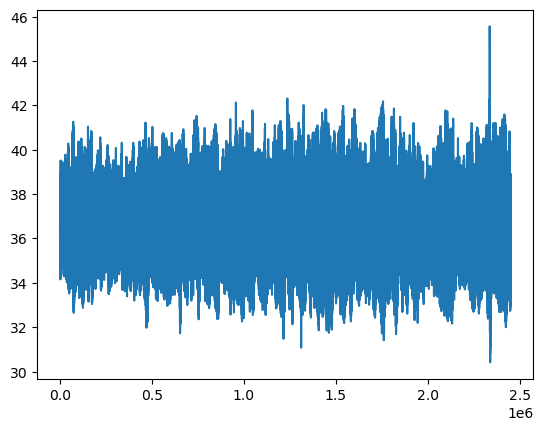

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

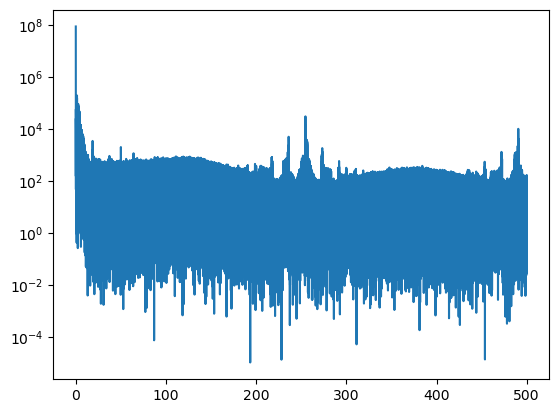

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

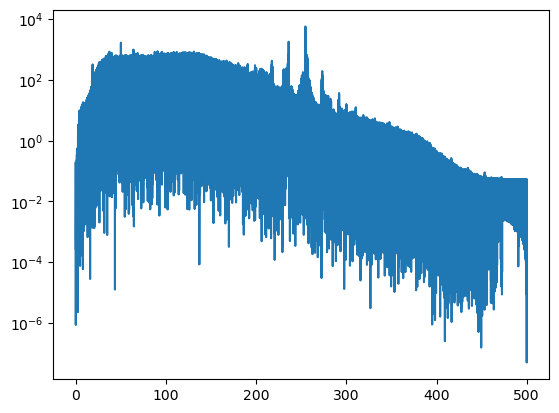

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

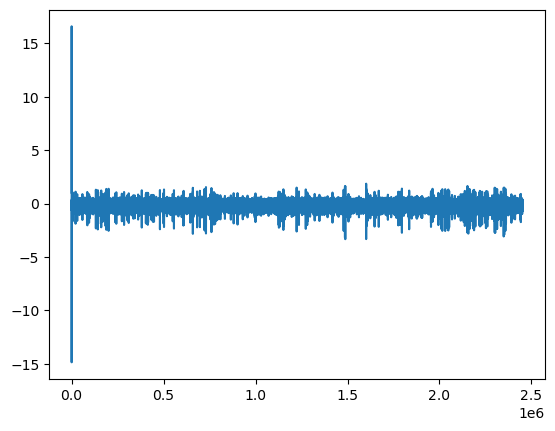

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.015
1        42.669
2        50.361
3        53.586
4        46.418
...         ...
2451579  37.036
2451580  36.954
2451581  36.873
2451582  36.948
2451583  37.068

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

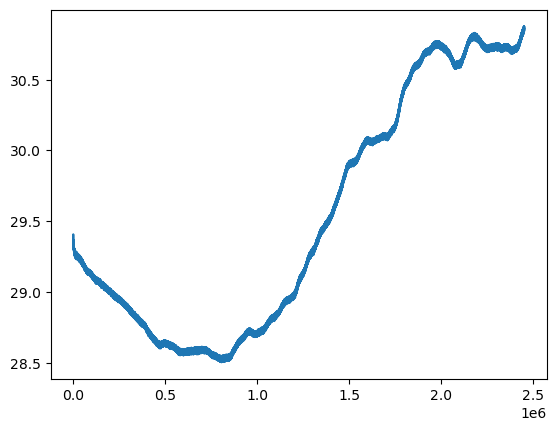

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

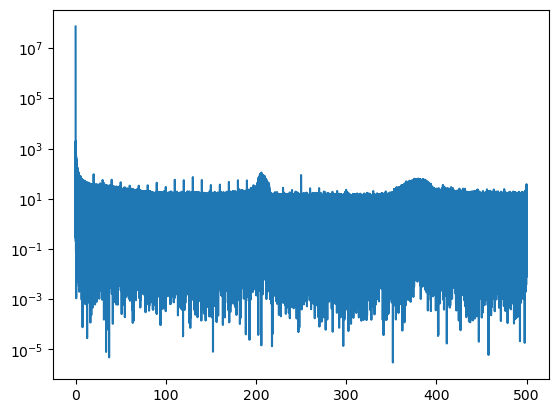

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

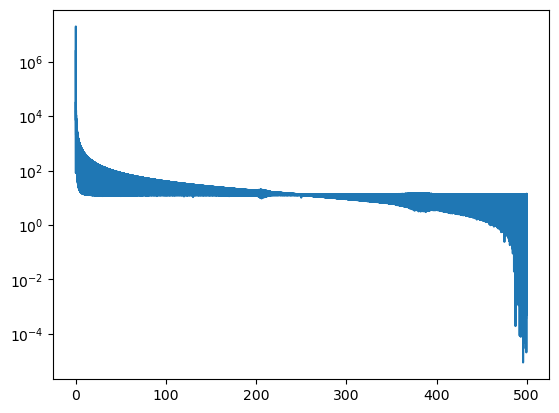

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

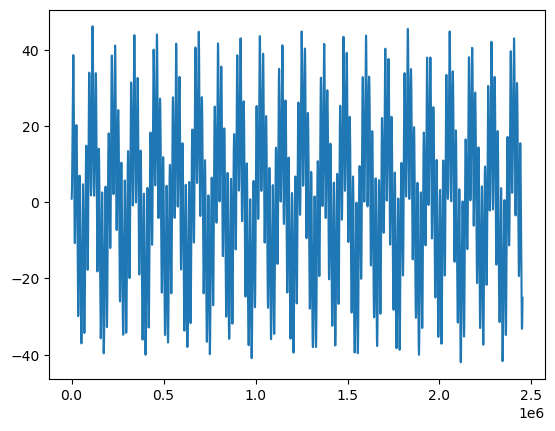

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.941
1        40.941
2        40.941
3        40.941
4        40.942
...         ...
2451579  14.889
2451580  14.894
2451581  14.899
2451582  14.903
2451583  14.908

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.918  42.352     5.685     6.426    11.148     10
1              1  0.915  42.390     5.808     6.467    11.189     10
2              2  0.912  42.429     5.932     6.508    11.230     10
3              3  0.908  42.468     6.055     6.549    11.271     10
4              4  0.905  42.506     6.178     6.590    11.312     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  1.194  40.783     4.497     6.015     7.822     12
2451580  2451580  1.220  40.726     4.536     6.096     7.863     12
2451581  2451581  1.211  40.745     4.618     6.138     7.904     12
2451582  2451582  1.207  40.726     4.456     5.976     7.742     12
2451583  2451583  1.217  40.745     4.577     5.974     7.699     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.918  42.352     5.685     6.426    11.148     10  38.015   
1              1  0.915  42.390     5.808     6.467    11.189     10  42.669   
2              2  0.912  42.429     5.932     6.508    11.230     10  50.361   
3              3  0.908  42.468     6.055     6.549    11.271     10  53.586   
4              4  0.905  42.506     6.178     6.590    11.312     10  46.418   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  1.194  40.783     4.497     6.015     7.822     12  37.036   
2451580  2451580  1.220  40.726     4.536     6.096     7.863     12  36.954   
2451581  2451581  1.211  40.745     4.618     6.138     7.904     12  36.873   
2451582  2451582  1.207  40.726     4.456     5.976     7.742     12  36.948   
2451583  2451583  1.217  40.745     4.577     5.974     7.699     12  37.068   

            gsr     skt  
0         0.000  40.941  
1         0.000  40.941  
2         0.000  40.941  
3         0.000  40.941  
4         0.000  40.942  
...         ...     ...  
2451579  13.850  14.889  
2451580  13.850  14.894  
2451581  13.850  14.899  
2451582  13.851  14.903  
2451583  13.851  14.908  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.668474  0.651948  0.621939  0.792741  0.086957  0.014947   
221502    221502  0.660133  0.655033  0.621939  0.792669  0.090580  0.014902   
221503    221503  0.661384  0.649055  0.621939  0.792586  0.088206  0.014902   
221504    221504  0.673478  0.641728  0.622042  0.792514  0.094203  0.016719   
221505    221505  0.666806  0.644042  0.622042  0.792431  0.091829  0.018627   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.688907  0.651562  0.263387  0.355090  0.414668  0.063332   
2331580  2331580  0.690158  0.640185  0.263387  0.355174  0.414668  0.059697   
2331581  2331581  0.695580  0.625337  0.263284  0.355257  0.415917  0.063377   
2331582  2331582  0.698499  0.634593  0.263284  0.355341  0.414668  0.065240   
2331583  2331583  0.695580  0.652333  0.263284  0.355424  0.412294  0.061560   

         emg_coru  emg_trap  video  
221501   0.037451  0.100656      8  
221502   0.053689  0.100577      8  
221503   0.053892  0.105400      8  
221504   0.062113  0.103819      8  
221505   0.058155  0.098996      8  
...           ...       ...    ...  
2331579  0.032985  0.199652      1  
2331580  0.028925  0.197992      1  
2331581  0.032985  0.189926      1  
2331582  0.037146  0.186645      1  
2331583  0.029027  0.181782      1  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.668474  0.651948  0.621939  0.086957  0.792741  0.014947   
221502    221502  0.660133  0.655033  0.621939  0.090580  0.792669  0.014902   
221503    221503  0.661384  0.649055  0.621939  0.088206  0.792586  0.014902   
221504    221504  0.673478  0.641728  0.622042  0.094203  0.792514  0.016719   
221505    221505  0.666806  0.644042  0.622042  0.091829  0.792431  0.018627   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.688907  0.651562  0.263387  0.414668  0.355090  0.063332   
2331580  2331580  0.690158  0.640185  0.263387  0.414668  0.355174  0.059697   
2331581  2331581  0.695580  0.625337  0.263284  0.415917  0.355257  0.063377   
2331582  2331582  0.698499  0.634593  0.263284  0.414668  0.355341  0.065240   
2331583  2331583  0.695580  0.652333  0.263284  0.412294  0.355424  0.061560   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.632611  0.638257  0.622146  0.092954  0.791286  0.022262  0.049731   
221540   0.636781  0.629965  0.622250  0.091829  0.789748  0.020444  0.058053   
221560   0.617598  0.647898  0.622457  0.093078  0.788210  0.018627  0.058155   
221580   0.636781  0.648284  0.622561  0.096577  0.786672  0.016810  0.062316   
221600   0.610509  0.649634  0.622769  0.094203  0.785122  0.016810  0.066477   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.763136  0.665445  0.263491  0.417166  0.348496  0.052247  0.028925   
2331520  0.257715  0.653490  0.263491  0.417166  0.350178  0.059652  0.033086   
2331540  0.392410  0.644427  0.263387  0.419540  0.351847  0.061560  0.033188   
2331560  0.657214  0.645199  0.263387  0.417041  0.353504  0.061515  0.024764   
2331580  0.690158  0.640185  0.263387  0.414668  0.355174  0.059697  0.028925   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.632611  0.638257  0.622146  0.092954  0.791286  0.022262  0.049731   
1      0.636781  0.629965  0.622250  0.091829  0.789748  0.020444  0.058053   
2      0.617598  0.647898  0.622457  0.093078  0.788210  0.018627  0.058155   
3      0.636781  0.648284  0.622561  0.096577  0.786672  0.016810  0.062316   
4      0.610509  0.649634  0.622769  0.094203  0.785122  0.016810  0.066477   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.763136  0.665445  0.263491  0.417166  0.348496  0.052247  0.028925   
63500  0.257715  0.653490  0.263491  0.417166  0.350178  0.059652  0.033086   
63501  0.392410  0.644427  0.263387  0.419540  0.351847  0.061560  0.033188   
63502  0.657214  0.645199  0.263387  0.417041  0.353504  0.061515  0.024764   
63503  0.690158  0.640185  0.263387  0.414668  0.355174  0.059697  0.028925   

       emg_trap  valence  arousal  
0      0.077845    5.000    5.133  
1      0.063217    5.000    5.132  
2      0.051830    5.000    5.134  
3      0.042144    5.000    5.136  
4      0.042144    5.000    5.131  
...         ...      ...      ...  
63499  0.059975    6.367    5.841  
63500  0.105440    6.367    5.841  
63501  0.243338    6.367    5.841  
63502  0.272673    6.367    5.841  
63503  0.197992    6.367    5.841  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.632611  0.638257  0.622146  0.092954  0.791286  0.022262  0.049731   
1      0.636781  0.629965  0.622250  0.091829  0.789748  0.020444  0.058053   
2      0.617598  0.647898  0.622457  0.093078  0.788210  0.018627  0.058155   
3      0.636781  0.648284  0.622561  0.096577  0.786672  0.016810  0.062316   
4      0.610509  0.649634  0.622769  0.094203  0.785122  0.016810  0.066477   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.636781  0.679329  0.263699  0.419540  0.341807  0.048476  0.033086   
63496  0.631359  0.629772  0.263595  0.423038  0.343488  0.052156  0.041307   
63497  0.620517  0.707482  0.263595  0.420790  0.345158  0.055972  0.037248   
63498  0.650542  0.629772  0.263595  0.419540  0.346827  0.057789  0.033188   
63499  0.763136  0.665445  0.263491  0.417166  0.348496  0.052247  0.028925   

       emg_trap  valence  arousal  
0      0.077845    5.000    5.133  
1      0.063217    5.000    5.132  
2      0.051830    5.000    5.134  
3      0.042144    5.000    5.136  
4      0.042144    5.000    5.131  
...         ...      ...      ...  
63495  0.051870    6.367    5.841  
63496  0.050210    6.367    5.841  
63497  0.051830    6.367    5.841  
63498  0.053491    6.367    5.841  
63499  0.059975    6.367    5.841  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.632611  0.638257  0.622146  0.092954  0.791286  0.022262  0.049731   
 1   0.636781  0.629965  0.622250  0.091829  0.789748  0.020444  0.058053   
 2   0.617598  0.647898  0.622457  0.093078  0.788210  0.018627  0.058155   
 3   0.636781  0.648284  0.622561  0.096577  0.786672  0.016810  0.062316   
 4   0.610509  0.649634  0.622769  0.094203  0.785122  0.016810  0.066477   
 5   0.638032  0.639028  0.622873  0.089455  0.783571  0.018627  0.066579   
 6   0.642202  0.664481  0.622976  0.086957  0.782021  0.016764  0.070638   
 7   0.644704  0.681450  0.623184  0.085707  0.780471  0.014856  0.070537   
 8   0.648874  0.653105  0.623288  0.089330  0.778921  0.014856  0.074698   
 9   0.640951  0.620131  0.623391  0.095327  0.777371  0.014856  0.070435   
 10  0.635530  0.646934  0.623495  0.103823  0.775809  0.014856  0.078859   
 11  0.625938  0.647513  0.623703  0.121939  0.774247  0.016719  0.074698   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.632611  0.638257  0.622146  0.092954  0.791286  0.022262  0.049731   
1     0.561301  0.640764  0.624325  0.139055  0.752295  0.014947  0.062316   
2     0.632611  0.653876  0.625675  0.195902  0.713078  0.005679  0.070740   
3     0.651793  0.657540  0.632005  0.240505  0.674958  0.011131  0.062113   
4     0.721852  0.626494  0.644666  0.188531  0.639055  0.014856  0.070638   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.639700  0.639028  0.270340  0.424413  0.162736  0.067239  0.033188   
2536  0.673895  0.657925  0.269095  0.411044  0.193058  0.076462  0.037146   
2537  0.205171  0.645199  0.267746  0.435282  0.228185  0.074644  0.024866   
2538  0.642202  0.653105  0.266293  0.473888  0.267045  0.046613  0.033086   
2539  0.670976  0.659468  0.264840  0.446152  0.308218  0.057835  0.028925   

             8         9        10  ...       193       194       195  \
0     0.077845  0.636781  0.629965  ...  0.090075  0.639799  0.624325   
1     0.292164  0.650542  0.642692  ...  0.632611  0.635172  0.625571   
2     0.034000  0.638032  0.650791  ...  0.661384  0.647320  0.631694   
3     0.027477  0.653044  0.648284  ...  0.703920  0.628423  0.644043   
4     0.092473  0.739366  0.628808  ...  0.693078  0.644620  0.660648   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.058354  0.639700  0.655611  ...  0.713511  0.604126  0.269095   
2536  0.051870  0.657214  0.632858  ...  0.546706  0.645006  0.267850   
2537  0.189808  0.628440  0.634015  ...  0.645121  0.639221  0.266293   
2538  0.051870  0.638032  0.634015  ...  0.695997  0.644813  0.264944   
2539  0.048628  0.662636  0.607212  ...  0.763136  0.665445  0.263491   

           196       197       198       199       200  valence  arousal  
0     0.138931  0.753869  0.013039  0.062215  0.128173    5.000  5.05396  
1     0.198151  0.714640  0.009314  0.074901  0.025975    5.000  5.00000  
2     0.244128  0.676448  0.011176  0.062215  0.030758    5.000  4.99988  
3     0.187406  0.640438  0.009314  0.066477  0.134696    5.000  5.00000  
4     0.168041  0.607529  0.013084  0.083223  0.040523    5.000  5.00008  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.415792  0.191746  0.076416  0.037146  0.048589    6.367  5.84100  
2536  0.436407  0.226707  0.083958  0.041409  0.077805    6.367  5.84100  
2537  0.473888  0.265435  0.052201  0.041307  0.056733    6.367  5.84100  
2538  0.451024  0.306549  0.061560  0.037349  0.051870    6.367  5.84100  
2539  0.417166  0.348496  0.052247  0.028925  0.059975    6.367  5.84100  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.632611  0.638257  0.622146  0.092954  0.791286  0.022262  0.049731   
1     0.561301  0.640764  0.624325  0.139055  0.752295  0.014947  0.062316   
2     0.632611  0.653876  0.625675  0.195902  0.713078  0.005679  0.070740   
3     0.651793  0.657540  0.632005  0.240505  0.674958  0.011131  0.062113   
4     0.721852  0.626494  0.644666  0.188531  0.639055  0.014856  0.070638   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.639700  0.639028  0.270340  0.424413  0.162736  0.067239  0.033188   
2536  0.673895  0.657925  0.269095  0.411044  0.193058  0.076462  0.037146   
2537  0.205171  0.645199  0.267746  0.435282  0.228185  0.074644  0.024866   
2538  0.642202  0.653105  0.266293  0.473888  0.267045  0.046613  0.033086   
2539  0.670976  0.659468  0.264840  0.446152  0.308218  0.057835  0.028925   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub28.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.632611  0.638257  0.622146  0.092954  0.791286  0.022262  0.049731   
1     0.561301  0.640764  0.624325  0.139055  0.752295  0.014947  0.062316   
2     0.632611  0.653876  0.625675  0.195902  0.713078  0.005679  0.070740   
3     0.651793  0.657540  0.632005  0.240505  0.674958  0.011131  0.062113   
4     0.721852  0.626494  0.644666  0.188531  0.639055  0.014856  0.070638   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.639700  0.639028  0.270340  0.424413  0.162736  0.067239  0.033188   
2536  0.673895  0.657925  0.269095  0.411044  0.193058  0.076462  0.037146   
2537  0.205171  0.645199  0.267746  0.435282  0.228185  0.074644  0.024866   
2538  0.642202  0.653105  0.266293  0.473888  0.267045  0.046613  0.033086   
2539  0.670976  0.659468  0.264840  0.446152  0.308218  0.057835  0.028925   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub28.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.632611  0.638257  0.622146  0.092954  0.791286  0.022262  0.049731   
1     0.561301  0.640764  0.624325  0.139055  0.752295  0.014947  0.062316   
2     0.632611  0.653876  0.625675  0.195902  0.713078  0.005679  0.070740   
3     0.651793  0.657540  0.632005  0.240505  0.674958  0.011131  0.062113   
4     0.721852  0.626494  0.644666  0.188531  0.639055  0.014856  0.070638   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.639700  0.639028  0.270340  0.424413  0.162736  0.067239  0.033188   
2536  0.673895  0.657925  0.269095  0.411044  0.193058  0.076462  0.037146   
2537  0.205171  0.645199  0.267746  0.435282  0.228185  0.074644  0.024866   
2538  0.642202  0.653105  0.266293  0.473888  0.267045  0.046613  0.033086   
2539  0.670976  0.659468  0.264840  0.446152  0.308218  0.057835  0.028925   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub28.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.632611  0.638257  0.622146  0.092954  0.791286  0.022262  0.049731   
1     0.561301  0.640764  0.624325  0.139055  0.752295  0.014947  0.062316   
2     0.632611  0.653876  0.625675  0.195902  0.713078  0.005679  0.070740   
3     0.651793  0.657540  0.632005  0.240505  0.674958  0.011131  0.062113   
4     0.721852  0.626494  0.644666  0.188531  0.639055  0.014856  0.070638   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.639700  0.639028  0.270340  0.424413  0.162736  0.067239  0.033188   
2536  0.673895  0.657925  0.269095  0.411044  0.193058  0.076462  0.037146   
2537  0.205171  0.645199  0.267746  0.435282  0.228185  0.074644  0.024866   
2538  0.642202  0.653105  0.266293  0.473888  0.267045  0.046613  0.033086   
2539  0.670976  0.659468  0.264840  0.446152  0.308218  0.057835  0.028925   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub28.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.632611  0.638257  0.622146  0.092954  0.791286  0.022262  0.049731   
1     0.561301  0.640764  0.624325  0.139055  0.752295  0.014947  0.062316   
2     0.632611  0.653876  0.625675  0.195902  0.713078  0.005679  0.070740   
3     0.651793  0.657540  0.632005  0.240505  0.674958  0.011131  0.062113   
4     0.721852  0.626494  0.644666  0.188531  0.639055  0.014856  0.070638   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.639700  0.639028  0.270340  0.424413  0.162736  0.067239  0.033188   
2536  0.673895  0.657925  0.269095  0.411044  0.193058  0.076462  0.037146   
2537  0.205171  0.645199  0.267746  0.435282  0.228185  0.074644  0.024866   
2538  0.642202  0.653105  0.266293  0.473888  0.267045  0.046613  0.033086   
2539  0.670976  0.659468  0.264840  0.446152  0.308218  0.057835  0.028925   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub28.csv', index=False)